In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Market Value Model 

In [506]:
value_all_players = pd.read_csv("upd_pldata.csv")

In [517]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

value_all_players.columns = value_all_players.columns.str.replace('.', '_')
value_all_players.columns = value_all_players.columns.str.replace('___', '_')
value_all_players.columns = value_all_players.columns.str.replace(' ', '_')

In [518]:
value_all_players.shape

(5700, 59)

## Preliminary Vizualizations

In [519]:
final_value_all_players = pd.DataFrame(value_all_players, columns = ["Name"])
final_value_all_players["actual"] = value_all_players['Value'].copy()

Text(0.5, 1.0, 'Value vs. Potential')

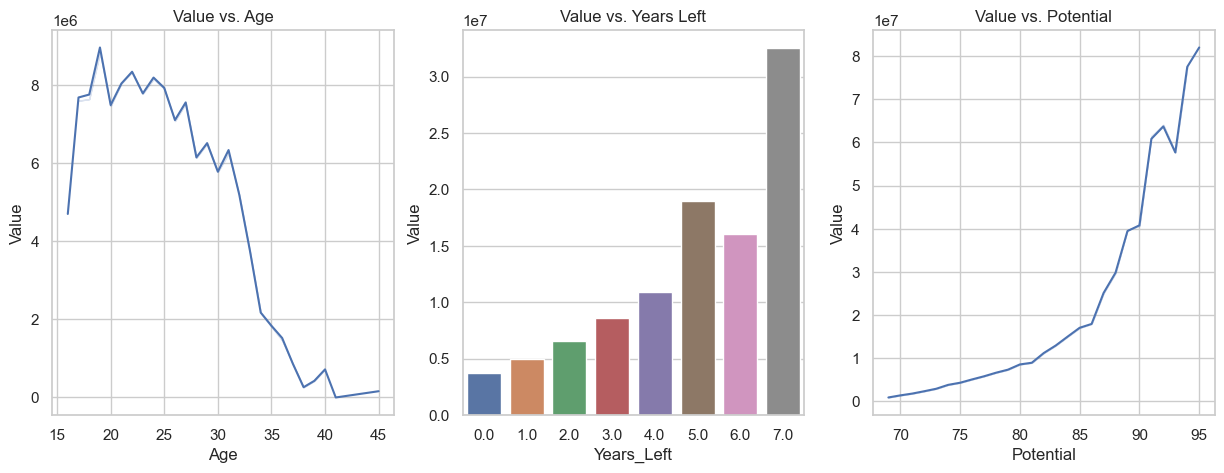

In [520]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5), sharex = False, sharey = False)

sns.lineplot(data=value_all_players, x="Age", y="Value", errorbar=('ci', False), ax = axarr[0]).set_title('Value vs. Age')
sns.barplot(data=value_all_players, x=(value_all_players["Years_Left"]), y="Value", errorbar=('ci', False), ax = axarr[1]).set_title('Value vs. Years Left')
sns.lineplot(data=value_all_players, x="Potential", y="Value", errorbar=('ci', False), ax = axarr[2]).set_title('Value vs. Potential')

## Prepare Data for Modeling

In [521]:
from sklearn.model_selection import train_test_split
value_all_train, value_all_test = train_test_split(value_all_players, test_size = .2, shuffle = True)

#dropping categeorical info we won't use for modeling
value_all_train = value_all_train.drop(["Name", "field_position","Wage", "Release_clause"], axis = 1)
value_all_test = value_all_test.drop(["Name", "field_position", "Wage", "Release_clause"], axis = 1)



#standardized and back to df
#Turn off for predictions?
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
value_all_train = pd.DataFrame(sc.fit_transform(value_all_train), columns = value_all_train.columns)
value_all_test = pd.DataFrame(sc.transform(value_all_test), columns = value_all_test.columns) #do NOT need to refit the standardization

#getting the target vector and deleting it from feature matrix

X_train_value = value_all_train.dropna(how='any', inplace=True)
X_train_value = value_all_train.drop(["Value"], axis = 1)
y_train_value = value_all_train["Value"]

 

X_test_value = value_all_test.dropna(how='any', inplace=True)
X_test_value = value_all_test.drop(["Value"], axis = 1)
y_test_value = value_all_test["Value"]

## Feature Selection

### Filter Approach w/ Univariate Statistical Tests

https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

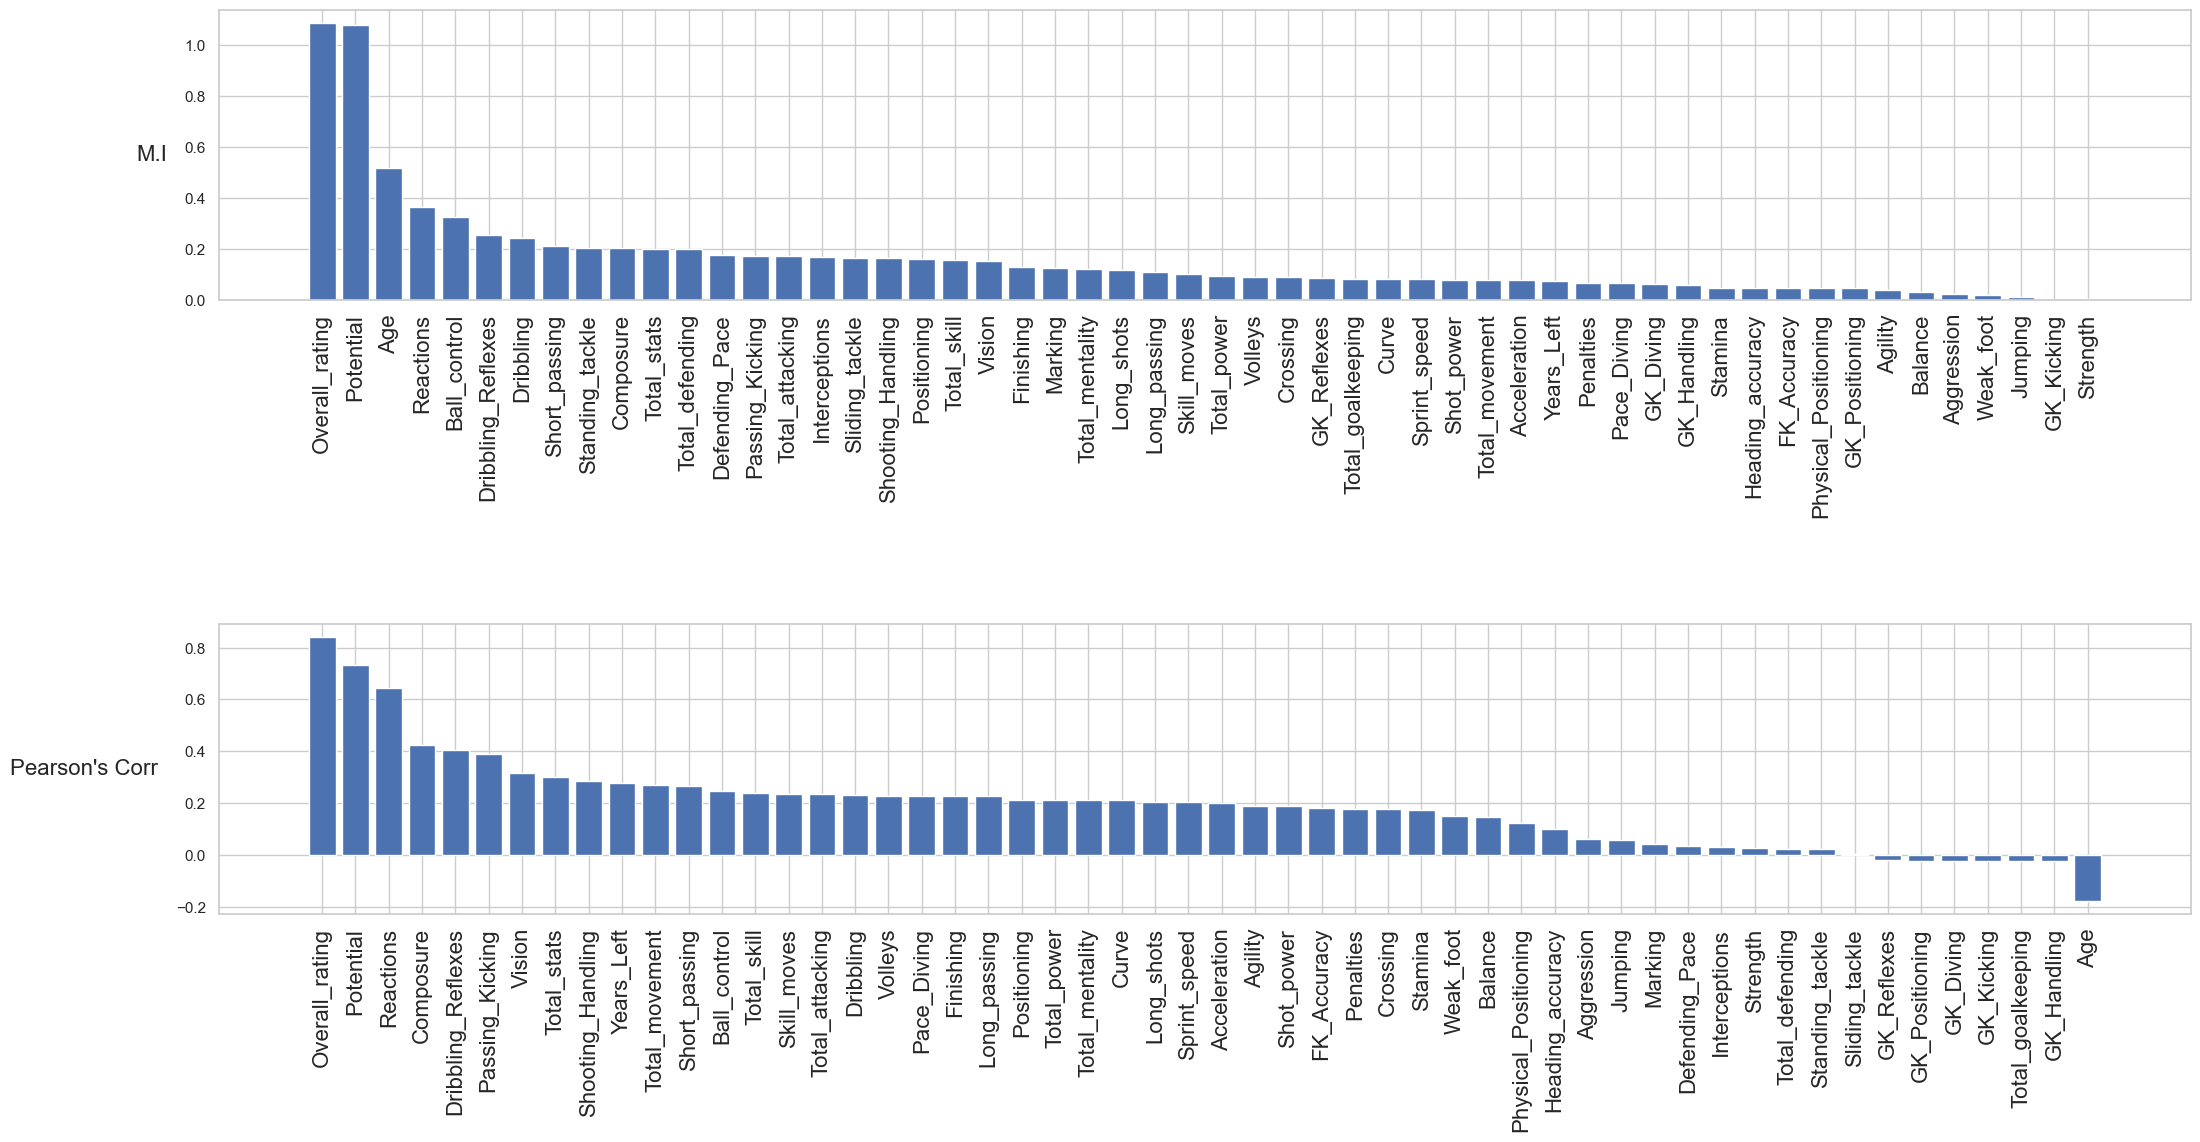

In [522]:
#create figure with 2 rows and 1 column. [row,column]
fig, axarr = plt.subplots(2, 1, figsize=(20,10), sharex = False, sharey = False)

#adjust rows
rows = ["M.I", "Pearson's Corr"]
for ax, row in zip(axarr[:], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=16, ha='right', va='center')

#adjust display
fig.tight_layout(w_pad = 0, h_pad = 18)
fig.subplots_adjust(left=0, top=0.95)
    

#Mutual Information
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X_train_value, y_train_value)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_value.columns
axarr[0].bar(mutual_info.sort_values(ascending=False).index, mutual_info.sort_values(ascending=False))
axarr[0].tick_params('x', labelrotation=90, labelsize = 16)



#Pearson's Correlation
from sklearn.feature_selection import r_regression

pearson_corr = r_regression(X_train_value, y_train_value)
pearson_corr = pd.Series(pearson_corr)
pearson_corr.index = X_train_value.columns #assign correspondning column name to correlation scores
axarr[1].bar(pearson_corr.sort_values(ascending=False).index, pearson_corr.sort_values(ascending=False)) #.index gives us names in associated descending order
axarr[1].tick_params('x', labelrotation=90, labelsize = 16)

#### Selecting Best Features

#### Mutual Information

In [523]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

#select top 15 features
selected_top_columns = SelectKBest(mutual_info_regression, k=15) 
selected_top_columns.fit(X_train_value, y_train_value) 

#get all sammples associated to these features using the selected feature names as index 
X_train_value_m_info_sel = X_train_value[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]
X_test_value_m_info_sel = X_test_value[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]

#### ANOVA

In [524]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#select top 15 features
selected_top_columns = SelectKBest(f_regression, k=15)
selected_top_columns.fit(X_train_value, y_train_value)

#get all sammples associated to these features using the selected feature names as index 
X_train_value_f_reg_sel = X_train_value[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]
X_test_value_f_reg_sel = X_test_value[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]

Note: Using r_regression to select the k best features doesn't give much importance to negatively correlated features even though they might be important for predictive purposes. So, we used f_regression instead. 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

### Recursive Feature Elimination w/ Cross-validation

#short explanation

45
['Age' 'Overall_rating' 'Total_stats' 'Total_attacking' 'Crossing'
 'Finishing' 'Heading_accuracy' 'Short_passing' 'Volleys' 'Total_skill'
 'Dribbling' 'Curve' 'FK_Accuracy' 'Long_passing' 'Ball_control'
 'Total_movement' 'Acceleration' 'Sprint_speed' 'Agility' 'Reactions'
 'Balance' 'Total_power' 'Shot_power' 'Jumping' 'Stamina' 'Strength'
 'Long_shots' 'Total_mentality' 'Aggression' 'Interceptions' 'Positioning'
 'Vision' 'Penalties' 'Total_defending' 'Marking' 'Standing_tackle'
 'Sliding_tackle' 'Total_goalkeeping' 'GK_Diving' 'GK_Handling'
 'GK_Kicking' 'GK_Positioning' 'GK_Reflexes' 'Shooting_Handling'
 'Defending_Pace']
8
['Age' 'Overall_rating' 'Potential' 'Finishing' 'FK_Accuracy' 'Stamina'
 'GK_Diving' 'Defending_Pace']
5
['Age' 'Overall_rating' 'Total_attacking' 'Ball_control' 'Standing_tackle']
14
['Overall_rating' 'Potential' 'Years_Left' 'Short_passing' 'Total_skill'
 'Ball_control' 'Total_movement' 'Reactions' 'Vision' 'Composure'
 'Skill_moves' 'Shooting_Handling' 'Pa

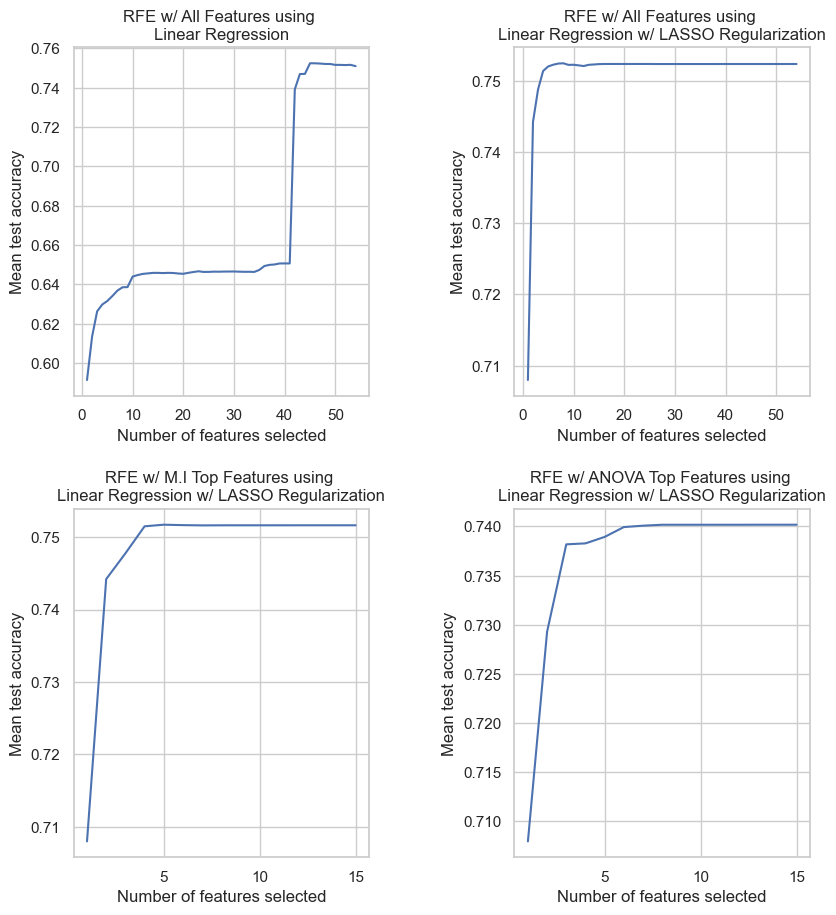

In [525]:
#create figure with 1 row and 3 columns. [row,column] 
fig, axarr = plt.subplots(2, 2, figsize=(9,9), sharex = False, sharey = False)
fig.tight_layout(w_pad = 7, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)


from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso


#all features RFECV w/ LR and NO regularization
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value, y_train_value)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_value.columns))
rfe_index = selector.get_feature_names_out(X_train_value.columns)


#all features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[0,0].plot(np.arange(n_scores) + 1, scores)
labs = axarr[0,0].set(title = "RFE w/ All Features using \nLinear Regression", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#all features RFECV w/ LR and LASSO regularization
estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value, y_train_value)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_value.columns))
rfe_LASSO_index = selector.get_feature_names_out(X_train_value.columns)


#all features RFECV w/ LR and LASSO regularization Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[0,1].plot(np.arange(n_scores) + 1, scores)
labs = axarr[0,1].set(title = "RFE w/ All Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#MI Features RFECV

estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value_m_info_sel, y_train_value)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_value_m_info_sel.columns))
mi_rfe_index = selector.get_feature_names_out(X_train_value_m_info_sel.columns)


#MI Features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[1,0].plot(np.arange(n_scores) + 1, scores)
labs = axarr[1,0].set(title = "RFE w/ M.I Top Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#ANOVA Features RFECV

estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_value_f_reg_sel, y_train_value)

print(selector.n_features_) # number of selected features
print(selector.get_feature_names_out(X_train_value_f_reg_sel.columns))#selected feature names
f_reg_rfe_index = selector.get_feature_names_out(X_train_value_f_reg_sel.columns)


#ANOVA Features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[1,1].plot(np.arange(n_scores) + 1, scores)
labs = axarr[1,1].set(title = "RFE w/ ANOVA Top Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")

In [526]:
#BIG COMMENTARY
#our LR must be feeding it bad coefficients, problem with feature importance analysis. Could this be due to a lack of regularization + multicollinearity
#yep, try LASSO; yep
#https://stats.stackexchange.com/questions/450703/is-feature-importance-in-random-forest-useless

## Modeling

In [531]:
#construct subset with the standout features.
sel_index = mi_rfe_index

X_train_value_sel = X_train_value[sel_index]
X_test_value_sel = X_test_value[sel_index]

### Holdout Set Performance (using selected features)

In [103]:
from sklearn.linear_model import Lasso
L = Lasso(alpha = 0.01)
L.fit(X_train_value_sel, y_train_value)
print(f"The model's score on the holdout test set is {L.score(X_test_value_sel, y_test_value)}")

The model's score on the holdout test set is 0.7408720171445111


In [104]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth = 5)
rfr.fit(X_train_value_sel, y_train_value)
print(f"The model's score on the holdout test set is {rfr.score(X_test_value_sel, y_test_value)}")

The model's score on the holdout test set is 0.9495861079513503


### Mini-Experiment: Cross Validation Run Time (based on # of selected features)

In [105]:
from sklearn.model_selection import cross_val_score
import time as tm


#cross-validation w/ all features

#LASSO
start = tm.time()
model_scores = cross_val_score(L, X_train_value, y_train_value, cv=5)
print(f"Using all features, the LASSO model's 5-fold cross-validation score is {(model_scores.mean())}")
running_secs = (tm.time() - start)
print(f"Run time: {running_secs}")


#RFR
start = tm.time()
model_scores = cross_val_score(rfr, X_train_value, y_train_value, cv=5)
print(f"Using all features, the Random Forest Regressor model's 5-fold cross-validation score is {(model_scores.mean())}")
running_secs = (tm.time() - start)
print(f"Run time: {running_secs}\n")

#cross-validation w/ selected features

#LASSO
start = tm.time()
model_scores = cross_val_score(L, X_train_value_sel, y_train_value, cv=5)
print(f"Using selected features, the LASSO model's 5-fold cross-validation score is {(model_scores.mean())}")
running_secs = (tm.time() - start)
print(f"Run time: {running_secs}")

#RFR
start = tm.time()
model_scores = cross_val_score(rfr, X_train_value_sel, y_train_value, cv=5)
print(f"Using selected features, the Random Forest Regressor model's 5-fold cross-validation score is {(model_scores.mean())}")
running_secs = (tm.time() - start)
print(f"Run time: {running_secs}")

Using all features, the LASSO model's 5-fold cross-validation score is 0.759119774244524
Run time: 0.06226038932800293
Using all features, the Random Forest Regressor model's 5-fold cross-validation score is 0.9551498431192836
Run time: 14.946359157562256

Using selected features, the LASSO model's 5-fold cross-validation score is 0.7513796036162785
Run time: 0.014987945556640625
Using selected features, the Random Forest Regressor model's 5-fold cross-validation score is 0.955894589030547
Run time: 0.8628628253936768


#### Take-Aways: Less features provides faster results and comparable accuracy, especially for Random Forest Regressor

### Learning Curves

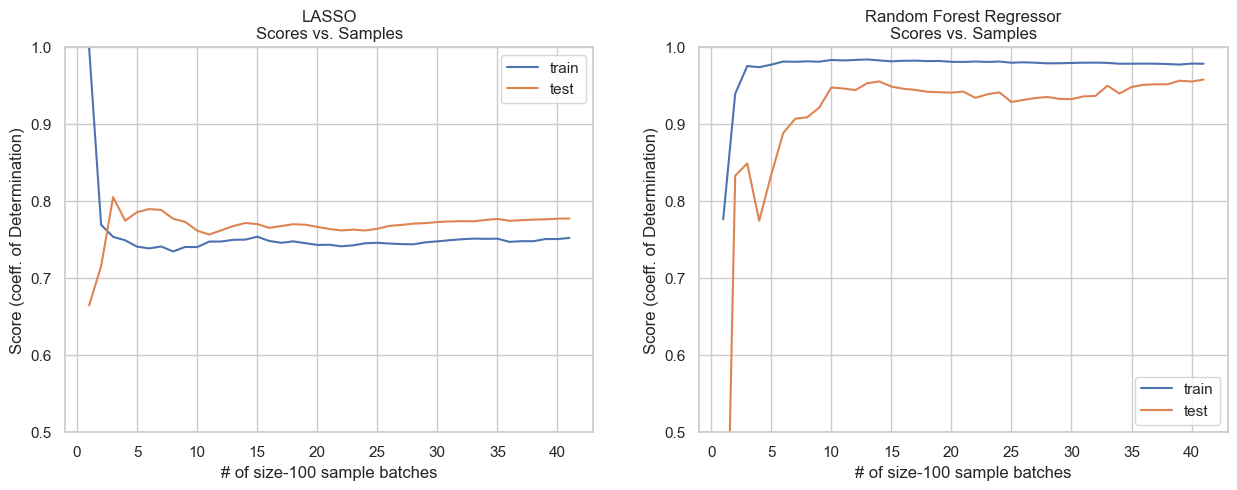

In [106]:
import warnings
warnings.filterwarnings('ignore')

#put both learning curves on the same plot
fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#initialize arrays to store scores
L_train_score_hist = []
L_test_score_hist = []
rfr_train_score_hist = []
rfr_test_score_hist = []

#loop through samples:
for i in range(5, len(X_train_value_sel),100):
    #LR
    #fit on training
    L = Lasso(alpha = 0.01)
    L.fit(X_train_value_sel.iloc[0:i], y_train_value.iloc[0:i])
    
    #score on training
    L_train_score_hist.append(L.score(X_train_value_sel.iloc[0:i],y_train_value.iloc[0:i]))  #update model's training score
    
    #score on testing
    L_test_score_hist.append(L.score(X_test_value_sel.iloc[0:i],y_test_value.iloc[0:i]))
    
    #RFR
    #fit on training
    rfr = RandomForestRegressor(max_depth = 5)
    rfr.fit(X_train_value_sel.iloc[0:i], y_train_value.iloc[0:i])
    
    #score on training
    rfr_train_score_hist.append(rfr.score(X_train_value_sel.iloc[0:i],y_train_value.iloc[0:i]))  #update model's training score
    
    #score on testing
    rfr_test_score_hist.append(rfr.score(X_test_value_sel.iloc[0:i],y_test_value.iloc[0:i]))

#Graph it

#LR
num_steps = len(L_train_score_hist)
axarr[0].plot(np.arange(num_steps) + 1, L_train_score_hist, label = "train")
axarr[0].plot(np.arange(num_steps) + 1, L_test_score_hist, label = "test")
axarr[0].axis(ymin=0.5,ymax=1)
#axarr[0].axis(xmin=0,xmax=100)

labs = axarr[0].set(title = "LASSO\nScores vs. Samples", xlabel = "# of size-100 sample batches", ylabel = "Score (coeff. of Determination)")
legend = axarr[0].legend()

#RFR
num_steps = len(L_train_score_hist)
axarr[1].plot(np.arange(num_steps) + 1, rfr_train_score_hist, label = "train")
axarr[1].plot(np.arange(num_steps) + 1, rfr_test_score_hist, label = "test")
axarr[1].axis(ymin=0.5,ymax=1)

labs = axarr[1].set(title = "Random Forest Regressor\nScores vs. Samples", xlabel = "# of size-100 sample batches", ylabel = "Score (coeff. of Determination)")
legend = axarr[1].legend()

#### Take-Aways: The LASSO model has a relatively low training accuracy indicating underfitting as the linear model is not complex enough to capture the patterns in the data. RandomForestRegressor alleviates this issue. 

#### Take-Aways: 
- Performace:  
- Mini-Experiment: Huge discrepancy between holdout method and cross validation method, due to sample size??? double check with larger dataset, and do an experiment

### Prediction Visualization
https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots

#### Preliminary

Need to use unstandardized data for the predictions and actual transfer market values to be in correct units: millions

In [107]:
#reverse standardization done in the prepare for modeling step
value_all_train = pd.DataFrame(sc.inverse_transform(value_all_train), columns = value_all_train.columns)
value_all_test = pd.DataFrame(sc.inverse_transform(value_all_test), columns = value_all_test.columns) #do NOT need to refit the standardization

#re-establish feature matrix and target vector
X_train_value = value_all_train.dropna(how='any', inplace=True)
X_train_value = value_all_train.drop(["Value"], axis = 1)
y_train_value = value_all_train["Value"]

 

X_test_value = value_all_test.dropna(how='any', inplace=True)
X_test_value = value_all_test.drop(["Value"], axis = 1)
y_test_value = value_all_test["Value"]

#use the selected features (ANOVA + RFE)
X_train_value_sel = X_train_value[f_reg_rfe_index] 
X_test_value_sel = X_test_value[f_reg_rfe_index]

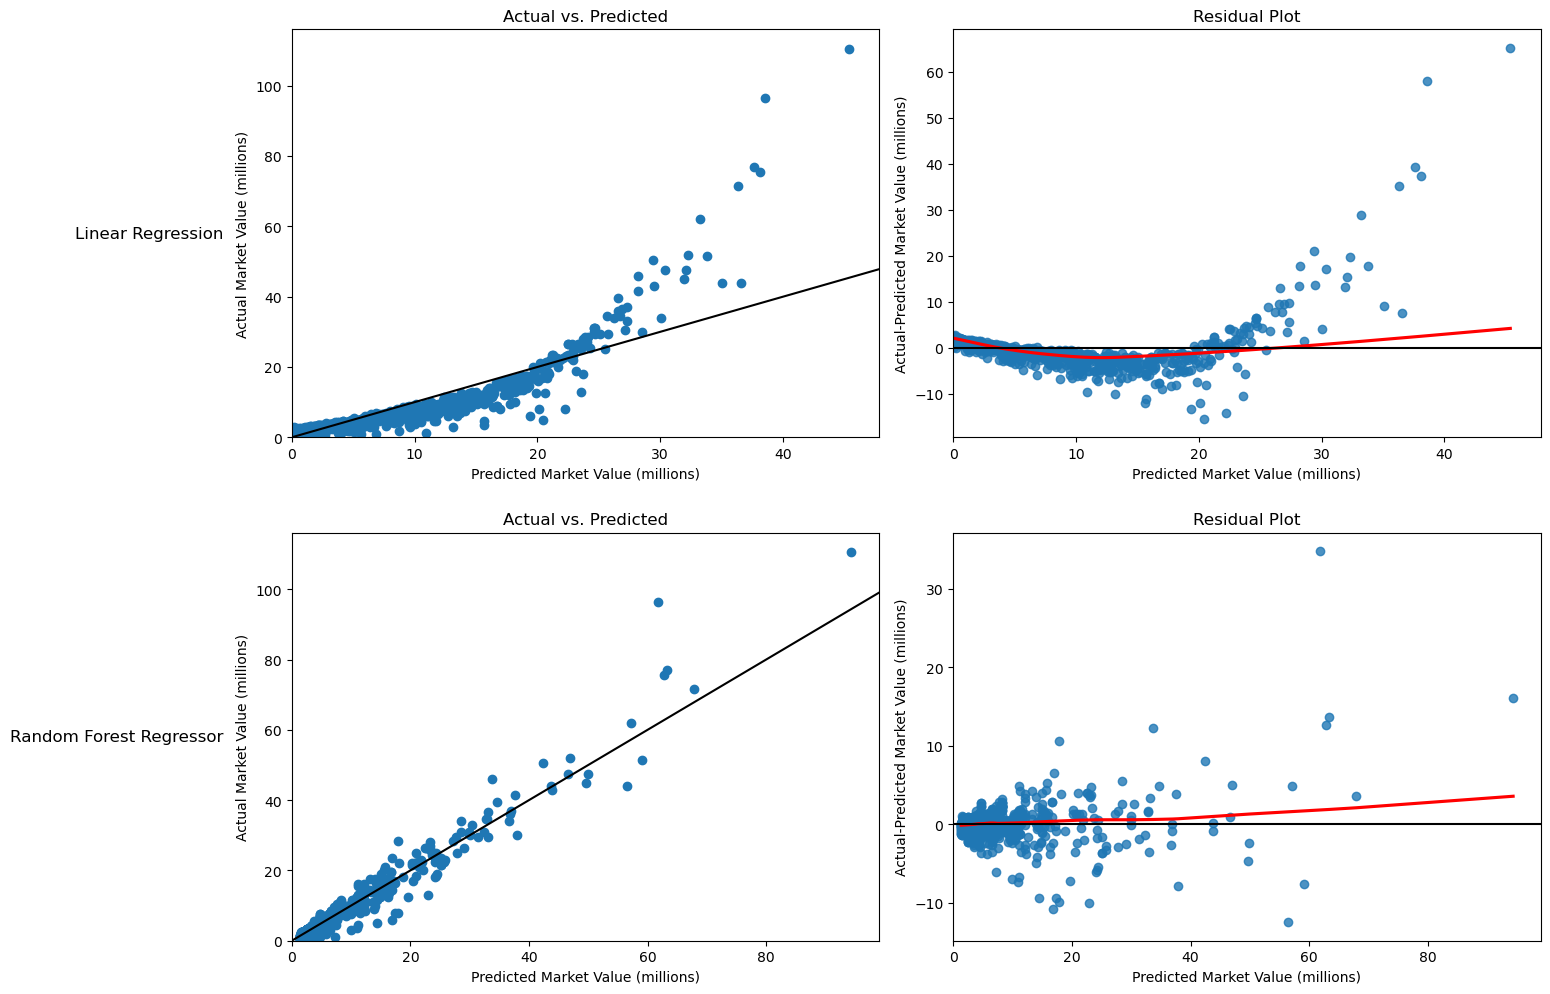

In [110]:
fig, axarr = plt.subplots(2, 2, figsize=(15,10), sharex = False, sharey = False)


rows = ["Linear Regression", "Random Forest Regressor"]
for ax, row in zip(axarr[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
fig.tight_layout(w_pad = 2, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)


    
#LASSO
L.fit(X_train_value_sel, y_train_value)
predictions12 = L.predict(X_test_value_sel)/1000000
actual = y_test_value/1000000

difference = np.subtract(actual, predictions12)

#plot actual vs. prediction + paramater line
axarr[0,0].axline((0, 0), slope=1, color = "black")
axarr[0,0].scatter(x = predictions12, y = actual)
axarr[0,0].axis(xmin=0,ymin=0)

#plot the residuals
sns.regplot(x = predictions12, y = difference, lowess=True, line_kws=dict(color="r"), ax = axarr[0,1])
axarr[0,1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[0,1].axis(xmin=0)



#graph descriptives
labs = axarr[0,0].set(title = "Actual vs. Predicted", xlabel = "Predicted Market Value (millions)", ylabel = "Actual Market Value (millions)")
labs = axarr[0,1].set(title = "Residual Plot", xlabel = "Predicted Market Value (millions)", ylabel = "Actual-Predicted Market Value (millions)") #add legend


#RFR
rfr.fit(X_train_value_sel, y_train_value)
predictions123 = rfr.predict(X_test_value_sel)/1000000
actual = y_test_value/1000000

difference = np.subtract(actual, predictions123)

#plot actual vs. prediction + paramater line
axarr[1,0].axline((0, 0), slope=1, color = "black")
axarr[1,0].scatter(x = predictions123, y = actual)
axarr[1,0].axis(xmin=0,ymin=0)

#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions123, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1,1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1,1].axis(xmin=0)

#graph descriptions
labs = axarr[1,0].set(title = "Actual vs. Predicted", xlabel = "Predicted Market Value (millions)", ylabel = "Actual Market Value (millions)")
labs = axarr[1,1].set(title = "Residual Plot", xlabel = "Predicted Market Value (millions)", ylabel = "Actual-Predicted Market Value (millions)") #add legend

#### Take-Aways: The random forest regressor is able to learn a non-linear pattern that LASSO can't pick up on. Thus, it provides much better predictions. Transforming to polynomial features may be able to address the linear model's underfitting issue.

# Transfer Fee Model (updated)

## Import appropriate dataset

In [237]:
tf2_data = pd.read_csv("changed_fifa_transfer fee_final.csv")
tf2_data.shape #dimensions

(708, 78)

In [238]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#clean column names
tf2_data.columns = tf2_data.columns.str.replace('.', '_')
tf2_data.columns = tf2_data.columns.str.replace('___', '_')
tf2_data.columns = tf2_data.columns.str.replace(' ', '_')

In [239]:
tf2_data.head(3)

,age,fee_cleaned,value_eur,years_left,team,player_name,overall,potential,wage_eur,nationality_name,...,npxGA,npxGD,ppda_coef,oppda_coef,deep,deep_allowed,xpts,xpts_diff,SPI,tranfer_activity
0,27,13.0,7500000.0,1,Barcelona,Jasper Cillessen,79,82,90000.0,Netherlands,...,33.28594,66.191080,6.012152,15.064390,570,163,94.3800,3.3800,67.72,-487.0
1,22,16.5,3800000.0,2,Barcelona,Lucas Digne,76,83,70000.0,France,...,33.28594,66.191080,6.012152,15.064390,570,163,94.3800,3.3800,67.72,-487.0
2,25,1.5,425000.0,3,Eibar,Florian Lejeune,65,70,2000.0,France,...,47.45242,-0.608427,7.804410,7.974349,191,218,54.0253,11.0253,67.72,-487.0


In [240]:
#getting gk datasets
tf2_data_gk_index = tf2_data["position_x"] == "Goalkeeper"
tf2_data_gk = tf2_data[tf2_data_gk_index]

tf2_data_gk_index_2 = tf2_data_gk["fee_cleaned"] > 0
tf2_data_gk = tf2_data_gk[tf2_data_gk_index_2]

tf2_data_gk_index_3 = tf2_data_gk["years_left"] > 0
tf2_data_gk = tf2_data_gk[tf2_data_gk_index_3]

tf2_data_gk = tf2_data_gk.dropna(axis = 1)

In [241]:
tf2_data_gk.shape

(37, 72)

In [242]:
#getting data for field players
tf2_data_field_index = tf2_data["position_x"] != "Goalkeeper"
tf2_data_field = tf2_data[tf2_data_field_index]

tf2_data_field["fee_cleaned"] = tf2_data_field["fee_cleaned"] * 1000000


tf2_data_field_index_2 = tf2_data_field["fee_cleaned"] > 0
tf2_data_field = tf2_data_field[tf2_data_field_index_2]

tf2_data_field_index_3 = tf2_data_field["years_left"] > 0
tf2_data_field = tf2_data_field[tf2_data_field_index_3]

tf2_data_field = tf2_data_field.dropna()

In [243]:
tf2_data_field.shape

(414, 78)

NOTE: Goalkeeper dataset has very few samples, so we decided to omit and model only on field players dataset.

## Preliminary Data Analysis (Visualizations + Tables)

Text(0.5, 1.0, 'Transfer fee vs. Potential')

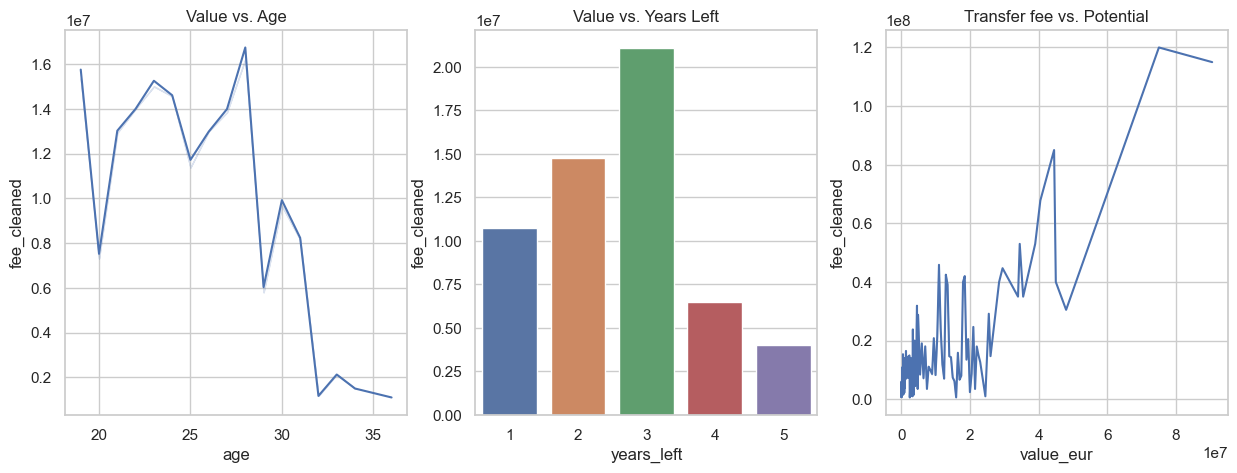

In [244]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5), sharex = False, sharey = False)

sns.lineplot(data=tf2_data_field, x="age", y="fee_cleaned", errorbar=('ci', False), ax = axarr[0]).set_title('Value vs. Age')
sns.barplot(data=tf2_data_field, x= "years_left", y="fee_cleaned", errorbar=('ci', False), ax = axarr[1]).set_title('Value vs. Years Left')
sns.lineplot(data=tf2_data_field, x="value_eur", y="fee_cleaned", errorbar=('ci', False), ax = axarr[2]).set_title('Transfer fee vs. Potential')
#sns.lineplot(data = tf2_data_field, x = "value_eur", y = "fee_cleaned", ci = False,  ax = axarr[4]).set_title('Value vs. Potential')

## Preparing Data For Modeling + Feature Engineering

In [246]:
from sklearn.model_selection import train_test_split
field_tf_upd_train, field_tf_upd_test = train_test_split(tf2_data_field, test_size = .2, shuffle = True)


#re-clean; drop categorical, keep numerical
field_tf_upd_train = field_tf_upd_train.drop(["player_name","nationality_name","position_x","league_name_x_y"], axis = 1)
field_tf_upd_test= field_tf_upd_test.drop(["player_name","nationality_name","position_x","league_name_x_y"], axis = 1)


#feature engineering on training data
buyer_avg_tf = field_tf_upd_train.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_upd_train.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_upd_train = pd.merge(field_tf_upd_train, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_upd_train = pd.merge(field_tf_upd_train, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_upd_train = field_tf_upd_train.drop(["team"], axis = 1)
field_tf_upd_train = field_tf_upd_train.drop(["club_involved_name"], axis = 1)

#CAN'T do target encoding on test set, because we will get data leakage so we use the buyer_avg_tf and seller_avg_tf from the train set

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_upd_test = pd.merge(field_tf_upd_test, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_upd_test = pd.merge(field_tf_upd_test, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_upd_test = field_tf_upd_test.drop(["team"], axis = 1)
field_tf_upd_test = field_tf_upd_test.drop(["club_involved_name"], axis = 1)


field_tf_upd_test = field_tf_upd_test.dropna() #lose about 15 test samples b/cuz some clubs in test set don't have avg.s calculated for them

#TURN OFF FOR PREDICTIONS
#standardized and back to df
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
field_tf_upd_train = pd.DataFrame(sc.fit_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)
field_tf_upd_test = pd.DataFrame(sc.transform(field_tf_upd_test), columns = field_tf_upd_test.columns)


#Choosing target vector, droping from feature matrix
X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
y_train_fee = field_tf_upd_train["fee_cleaned"]

X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
y_test_fee = field_tf_upd_test["fee_cleaned"]

Note (for future improvements): Use cross-validation standard scaling and target encoding, preferably with pipeline for more robust perfomance estimates!!!

## Feature selection

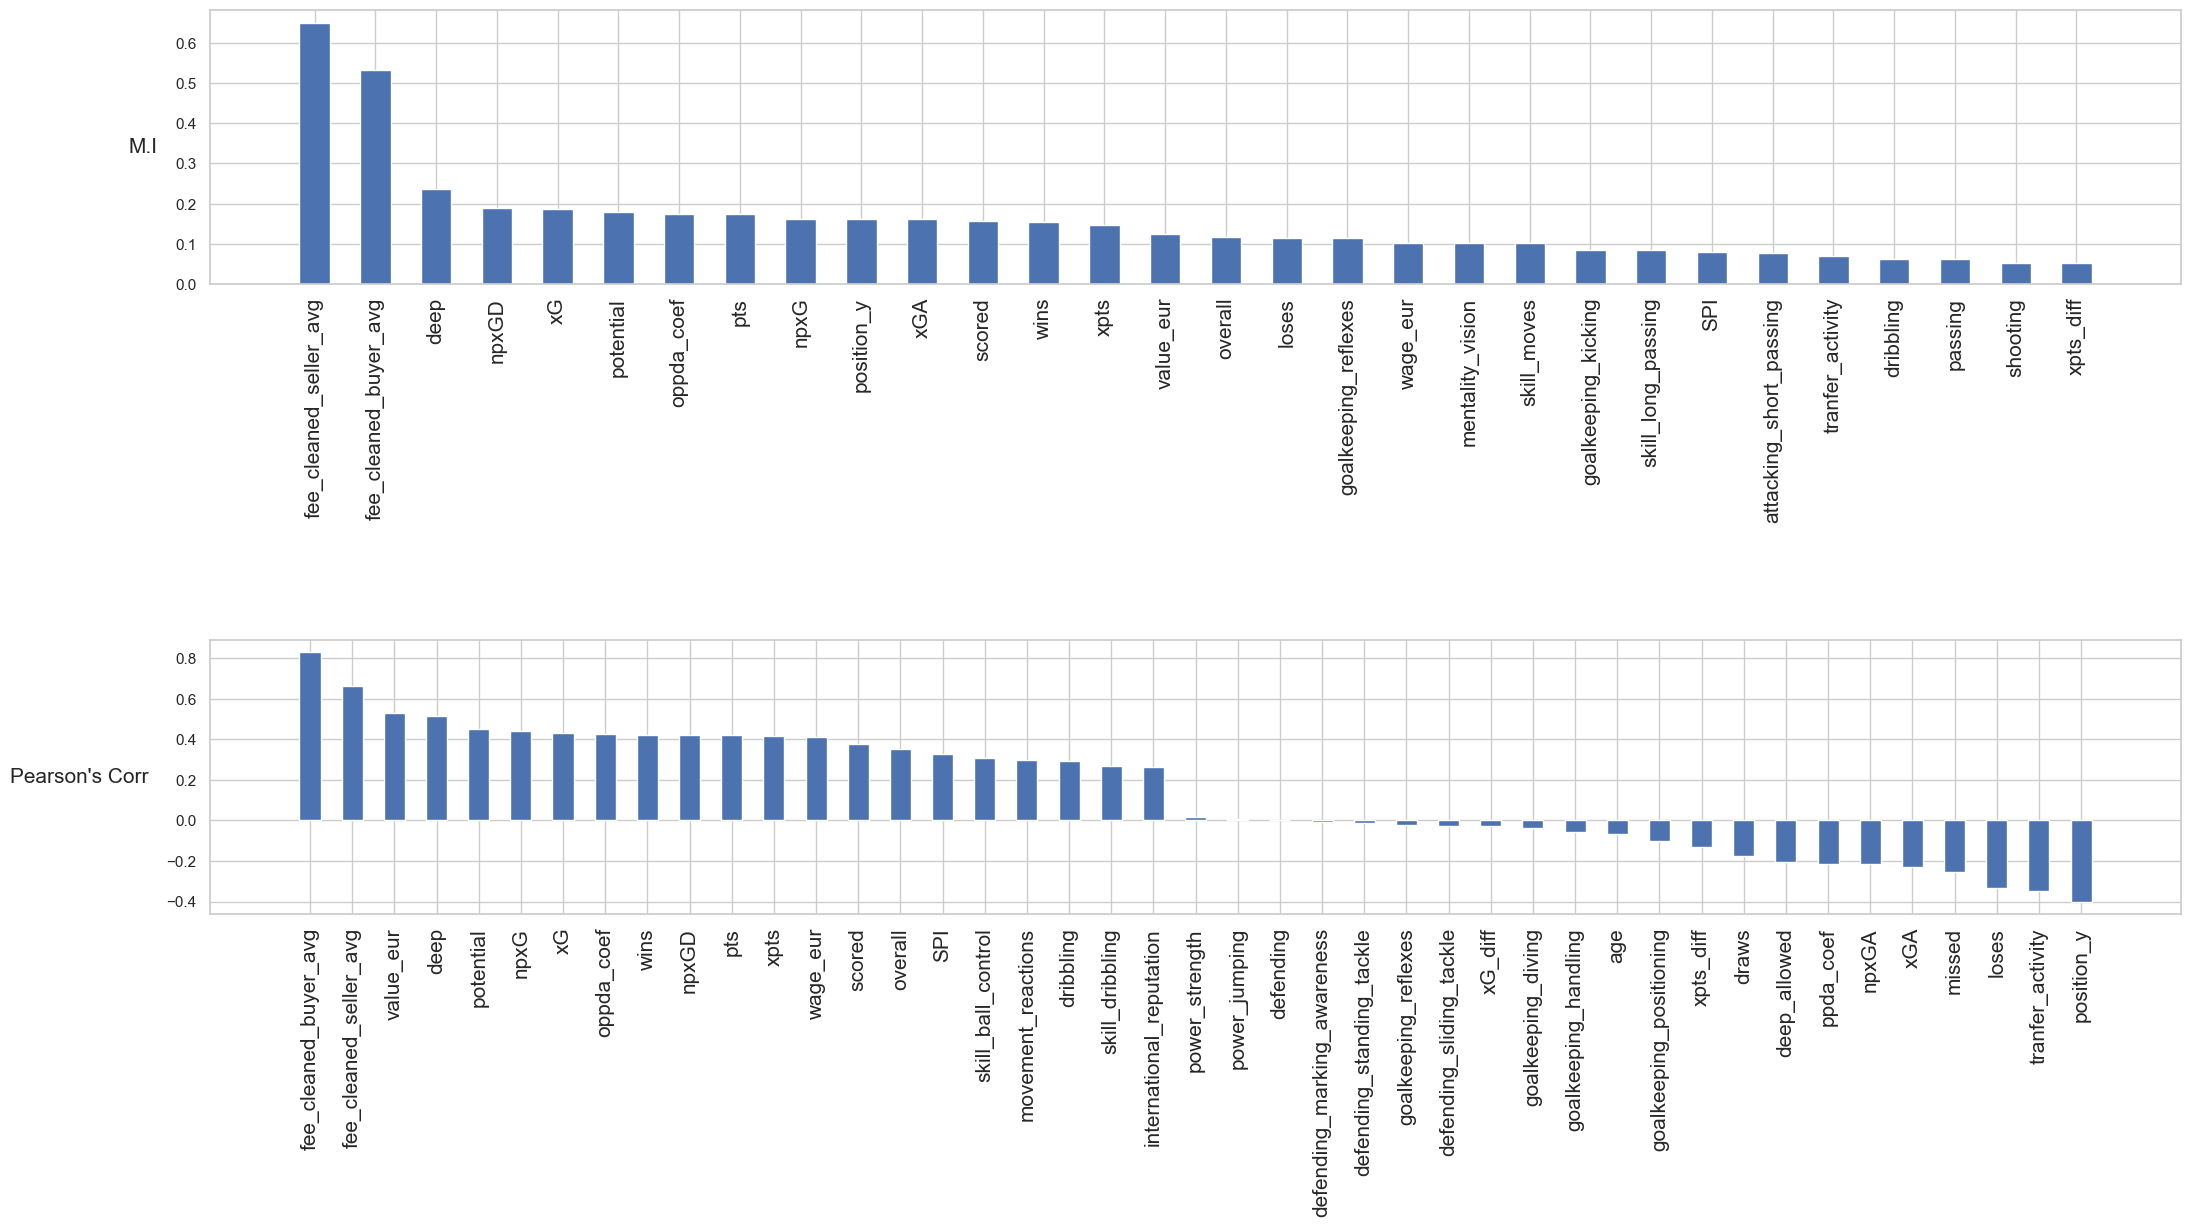

In [247]:
#create figure with 2 rows and 1 column. [row,column]
fig, axarr = plt.subplots(2, 1, figsize=(20,10), sharex = False, sharey = False)

#adjust rows
rows = ["M.I", "Pearson's Corr"]
for ax, row in zip(axarr[:], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=15, ha='right', va='center')

#adjust display
fig.tight_layout(w_pad = 0, h_pad = 20)
fig.subplots_adjust(left=0, top=0.95)
    

#Mutual Information
from sklearn.feature_selection import mutual_info_regression

mutual_info = mutual_info_regression(X_train_fee, y_train_fee)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_fee.columns #assign correspondning column name to correlation scores
mutual_info = mutual_info.sort_values(ascending = False)

axarr[0].bar(mutual_info.index[0:30], mutual_info.sort_values(ascending = False)[0:30], width = 0.5) 
axarr[0].tick_params('x', labelrotation=90, labelsize = 15)



#Pearson's Correlation
from sklearn.feature_selection import r_regression

pearson_corr = r_regression(X_train_fee, y_train_fee)
pearson_corr = pd.Series(pearson_corr)
pearson_corr.index = X_train_fee.columns #assign correspondning column name to correlation scores
pearson_corr = pearson_corr.sort_values(ascending = False)

# slice out middle values
middle_index = len(pearson_corr) // 2
corr_vals = np.concatenate((pearson_corr[:middle_index-15], pearson_corr[middle_index+15:]))
col_names = (np.concatenate((pearson_corr.index[:middle_index-15], pearson_corr.index[middle_index+15:])))

axarr[1].bar(col_names, corr_vals, width = 0.5)
axarr[1].tick_params('x', labelrotation=90, labelsize = 15)

#fix names for Mutual info

#### Selecting Best Features

#### Mutual Information

In [248]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

#select top 15 features
selected_top_columns = SelectKBest(mutual_info_regression, k=15) 
selected_top_columns.fit(X_train_fee, y_train_fee) 

#get all sammples associated to these features using the selected feature names as index 
X_train_fee_m_info_sel = X_train_fee[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]
X_test_fee_m_info_sel = X_test_fee[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]

#### ANOVA

In [249]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#select top 15 features
selected_top_columns = SelectKBest(f_regression, k=15)
selected_top_columns.fit(X_train_fee, y_train_fee)

#get all sammples associated to these features using the selected feature names as index 
X_train_fee_f_reg_sel = X_train_fee[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]
X_test_fee_f_reg_sel = X_test_fee[selected_top_columns.get_feature_names_out(selected_top_columns.feature_names_in_)]

Note: Using r_regression to select the k best features doesn't give much importance to negatively correlated features even though they might be important for predictive purposes. So, we used f_regression instead. 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression

### Recursive Feature Elimination w/ Cross-validation

Explanation of RFE!@
NOTE: used Lasso cuz it's much faster than RFR

6
['value_eur' 'xG' 'xGA' 'npxGD' 'fee_cleaned_buyer_avg'
 'fee_cleaned_seller_avg']
3
['value_eur' 'fee_cleaned_buyer_avg' 'fee_cleaned_seller_avg']
3
['value_eur' 'fee_cleaned_buyer_avg' 'fee_cleaned_seller_avg']
3
['value_eur' 'fee_cleaned_buyer_avg' 'fee_cleaned_seller_avg']


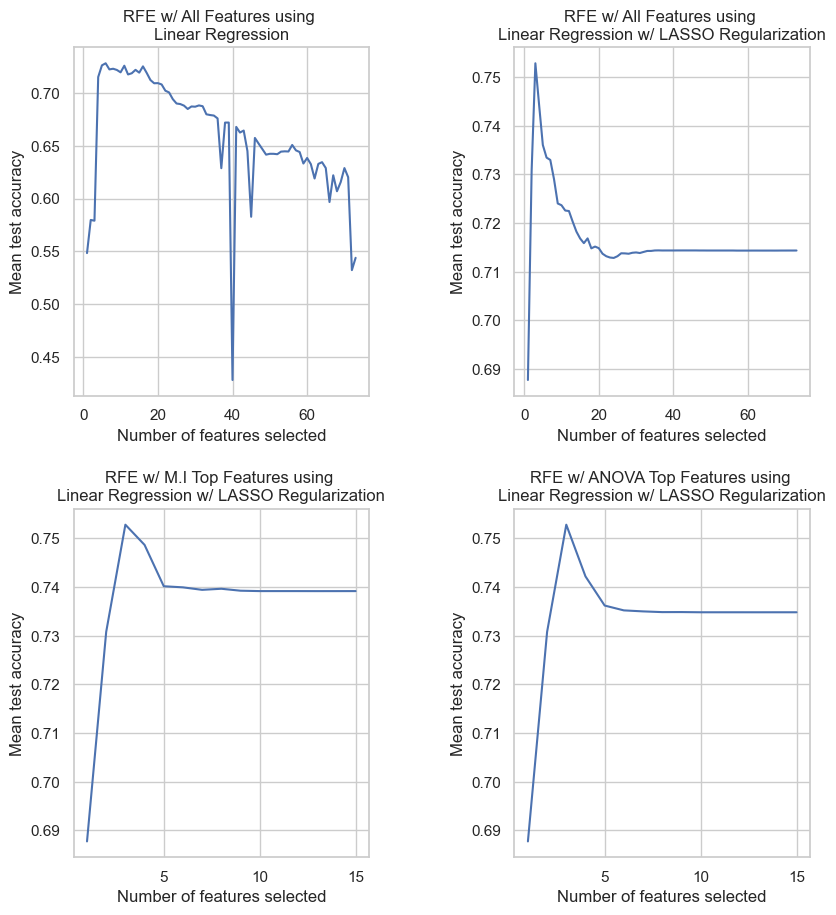

In [250]:
#create figure with 1 row and 3 columns. [row,column] 
fig, axarr = plt.subplots(2, 2, figsize=(9,9), sharex = False, sharey = False)
fig.tight_layout(w_pad = 7, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)


from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression



#all features RFECV w/ LR and NO regularization
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_fee, y_train_fee)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_fee.columns))
#print the feature names too
#print(selector.cv_results_)
rfe_index = X_train_fee.columns[selector.get_support()]
X_train_fee_rfe = X_train_fee[rfe_index]

#all features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[0,0].plot(np.arange(n_scores) + 1, scores)
labs = axarr[0,0].set(title = "RFE w/ All Features using \nLinear Regression", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#all features RFECV w/ LR and LASSO regularization
estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_fee, y_train_fee)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_fee.columns))
#print the feature names too
#print(selector.cv_results_)
rfe_LASSO_index = X_train_fee.columns[selector.get_support()]
X_train_fee_rfe = X_train_fee[rfe_LASSO_index]

#all features RFECV w/ LR and LASSO regularization Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[0,1].plot(np.arange(n_scores) + 1, scores)
labs = axarr[0,1].set(title = "RFE w/ All Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#MI Features RFECV

estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_fee_m_info_sel, y_train_fee)

print(selector.n_features_)
print(selector.get_feature_names_out(X_train_fee_m_info_sel.columns))
#print(selector.cv_results_)
mi_rfe_index = X_train_fee_m_info_sel.columns[selector.get_support()]
X_train_fee_mi_rfe = X_train_fee_m_info_sel[mi_rfe_index]

#MI Features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[1,0].plot(np.arange(n_scores) + 1, scores)
labs = axarr[1,0].set(title = "RFE w/ M.I Top Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")


#ANOVA Features RFECV

estimator = Lasso(alpha = 0.01)
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train_fee_f_reg_sel, y_train_fee)

print(selector.n_features_) # number of selected features
print(selector.get_feature_names_out(X_train_fee_f_reg_sel.columns))#selected feature names


f_reg_rfe_index = selector.get_feature_names_out(X_train_fee_f_reg_sel.columns)
X_train_fee_f_reg_rfe = X_train_fee_f_reg_sel[f_reg_rfe_index]
X_test_fee_f_reg_rfe = X_test_fee_f_reg_sel[f_reg_rfe_index]

#ANOVA Features RFECV Vizualization
n_scores = len(selector.cv_results_["mean_test_score"])
scores = selector.cv_results_["mean_test_score"]

axarr[1,1].plot(np.arange(n_scores) + 1, scores)
labs = axarr[1,1].set(title = "RFE w/ ANOVA Top Features using \nLinear Regression w/ LASSO Regularization", xlabel = "Number of features selected", ylabel = "Mean test accuracy")

## Modeling
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://scikit-learn.org/stable/modules/grid_search.html#grid-search
- https://inria.github.io/scikit-learnmooc/python_scripts/cross_validation_nested.html#:~:text=As%20a%20conclusion%2C%20when%20optimizing,validation%20are%20often%20overly%20optimistic.
- https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection/65158#65158
- https://stats.stackexchange.com/questions/102842/what-to-do-after-nested-cross-validation
- https://stats.stackexchange.com/questions/27750/feature-selection-and-cross-validation/27751#27751

##### add a whole bunch of references!!!!

In [251]:
#which set should i take?? #least number of features seems like a valid idea; might be underfitting

#choose the 5 standout features from feature selection process + lit review
sel_index = ['value_eur', 'fee_cleaned_buyer_avg', 'fee_cleaned_seller_avg', 'age', 'potential']
X_train_fee_sel = X_train_fee[sel_index]
X_test_fee_sel = X_test_fee[sel_index]

### Hyperparameter Tuning + Performance Measures


In [252]:
#Because of the size of our dataset, the randomization of the train,test,split affects the
#finish explaining why

In [253]:
from sklearn.model_selection import cross_val_score, KFold
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)

#### Hyperparameter Tuning for RandomForestRegressor

##### GridSearchCV: Tries all combinations based on a provided parameter grid.

NOTE: Just used GridSearchCV because there wasn't that many possible combinations, so no need to estimate best parameters with RandomizedSearchCV.

In [254]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Create the parameter grid based on the results of random search 
param_grid = {
     'n_estimators': [250,500,750,1000],
     'max_features': ["auto", "sqrt"],
     'max_depth': [5,10,15,20],
}

rf = RandomForestRegressor()
rf_model = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = inner_cv, n_jobs = -1, verbose = 2, refit = True)

In [255]:
#holdout set
rf_model.fit(X_train_fee_sel, y_train_fee)
print(f"The model's score on the holdout test set is {rf_model.score(X_test_fee_sel, y_test_fee):.3f}")

#cross-val
model_scores = cross_val_score(rf_model.best_estimator_, X_tf_bias_train, y_tf_bias_train, cv = outer_cv)
print(f"The model's cross-validation score {model_scores.mean():.3f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
The model's score on the holdout test set is 0.578
The model's cross-validation score 0.544


#### Hyperparameter Tuning for LASSO

NOTE: Bypassed gridsearchcv by using lassocv

In [256]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

Lmod = LassoCV(alphas = np.linspace(start=0.01, stop=0.2, num=10), cv = inner_cv)

In [257]:
#holdout set
Lmod.fit(X_train_fee_sel, y_train_fee)
print(f"The model's score on the holdout test set is {Lmod.score(X_test_fee_sel, y_test_fee):.3f}")

#cross-val
model_scores = cross_val_score(Lmod, X_tf_bias_train, y_tf_bias_train, cv = outer_cv)
print(f"The model's cross-validation score {model_scores.mean():.3f}")

The model's score on the holdout test set is 0.509
The model's cross-validation score 0.655


In [258]:
best_rf = rf_model.best_estimator_

### Learning Curves

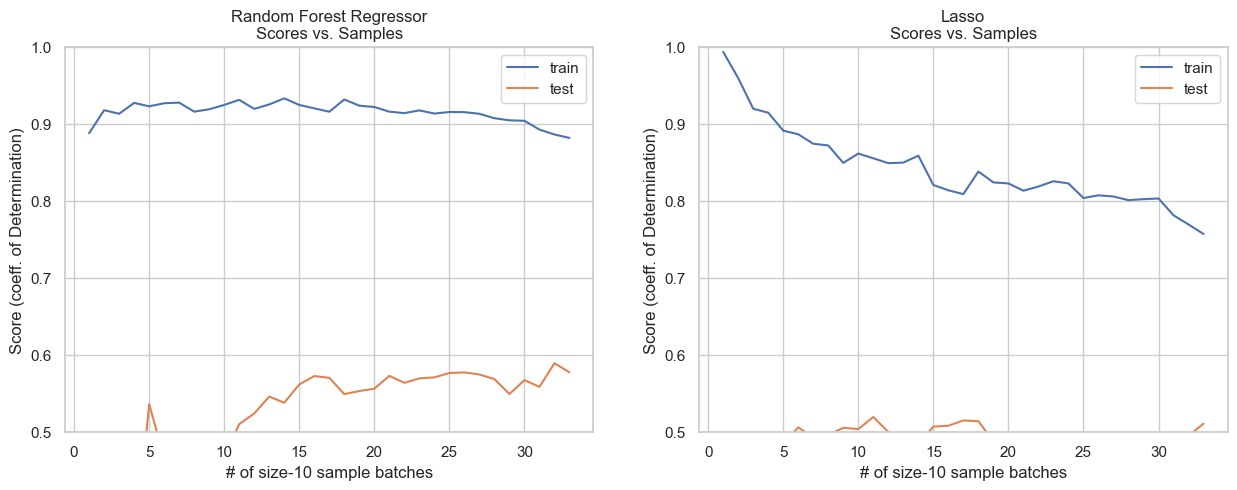

[CV] END ...max_depth=5, max_features=auto, n_estimators=500; total time=   2.6s
[CV] END ..max_depth=5, max_features=auto, n_estimators=1000; total time=   4.8s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=500; total time=   2.6s
[CV] END ...max_depth=5, max_features=sqrt, n_estimators=750; total time=   3.1s
[CV] END ..max_depth=5, max_features=sqrt, n_estimators=1000; total time=   4.2s
[CV] END ..max_depth=10, max_features=auto, n_estimators=750; total time=   3.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   1.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=500; total time=   2.1s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=750; total time=   3.7s
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time=   6.8s
[CV] END .max_depth=15, max_features=auto, n_estimators=1000; total time=   8.6s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=500; total time=   2.8s
[CV] END ..max_depth=15, max

In [259]:
import warnings
warnings.filterwarnings('ignore')

#put both learning curves on the same plot
fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

#initialize arrays to store scores
L_train_score_hist = []
L_test_score_hist = []
rfr_train_score_hist = []
rfr_test_score_hist = []

#loop through samples:
for i in range(5, len(X_train_fee_sel),10):
    
    #RFR
    
    #fit on training
    best_rf.fit(X_train_fee_sel.iloc[0:i], y_train_fee.iloc[0:i])
    
    #score on training
    rfr_train_score_hist.append(best_rf.score(X_train_fee_sel.iloc[0:i],y_train_fee.iloc[0:i]))  #update model's training score
    
    #cross-val score (on training)
    rfr_test_score_hist.append(best_rf.score(X_test_fee_sel.iloc[0:i], y_test_fee.iloc[0:i]))
    
    #Lasso
    
    #fit on training
    Lmod.fit(X_train_fee_sel.iloc[0:i], y_train_fee.iloc[0:i])
    test_score = cross_val_score(Lmod, X_train_fee_sel, y_train_fee, cv=outer_cv)
    
    #score on training
    L_train_score_hist.append(Lmod.score(X_train_fee_sel.iloc[0:i],y_train_fee.iloc[0:i]))  #update model's training score
    
    #cross-val score (on training)
    L_test_score_hist.append(Lmod.score(X_test_fee_sel.iloc[0:i],y_test_fee.iloc[0:i]).mean())

    
#Graph it

#RFR
num_steps = len(L_train_score_hist)
axarr[0].plot(np.arange(num_steps) + 1, rfr_train_score_hist, label = "train")
axarr[0].plot(np.arange(num_steps) + 1, rfr_test_score_hist, label = "test")
axarr[0].axis(ymin=0.5,ymax=1)

labs = axarr[0].set(title = "Random Forest Regressor\nScores vs. Samples", xlabel = "# of size-10 sample batches", ylabel = "Score (coeff. of Determination)")
legend = axarr[0].legend()

#Lasso
num_steps = len(L_train_score_hist)
axarr[1].plot(np.arange(num_steps) + 1, L_train_score_hist, label = "train")
axarr[1].plot(np.arange(num_steps) + 1, L_test_score_hist, label = "test")
axarr[1].axis(ymin=0.5,ymax=1)


labs = axarr[1].set(title = "Lasso\nScores vs. Samples", xlabel = "# of size-10 sample batches", ylabel = "Score (coeff. of Determination)")
legend = axarr[1].legend()

#### Take-Aways:

## Visualizations

#### Preliminary

Need to use unstandardized data for the predictions and actual transfer market values to be in millions

In [260]:
#reverse standardization done in the prepare for modeling step
field_tf_upd_train = pd.DataFrame(sc.inverse_transform(field_tf_upd_train), columns = field_tf_upd_train.columns)
field_tf_upd_test = pd.DataFrame(sc.inverse_transform(field_tf_upd_test), columns = field_tf_upd_test.columns) #do NOT need to refit the standardization

#re-establish feature matrix and target vector
X_train_fee = field_tf_upd_train.dropna(how='any', inplace=True)
X_train_fee = field_tf_upd_train.drop(["fee_cleaned"], axis = 1)
y_train_fee = field_tf_upd_train["fee_cleaned"]

 

X_test_fee = field_tf_upd_test.dropna(how='any', inplace=True)
X_test_fee = field_tf_upd_test.drop(["fee_cleaned"], axis = 1)
y_test_fee = field_tf_upd_test["fee_cleaned"]

#use the selected features
X_train_fee_sel = X_train_fee[sel_index] 
X_test_fee_sel = X_test_fee[sel_index]

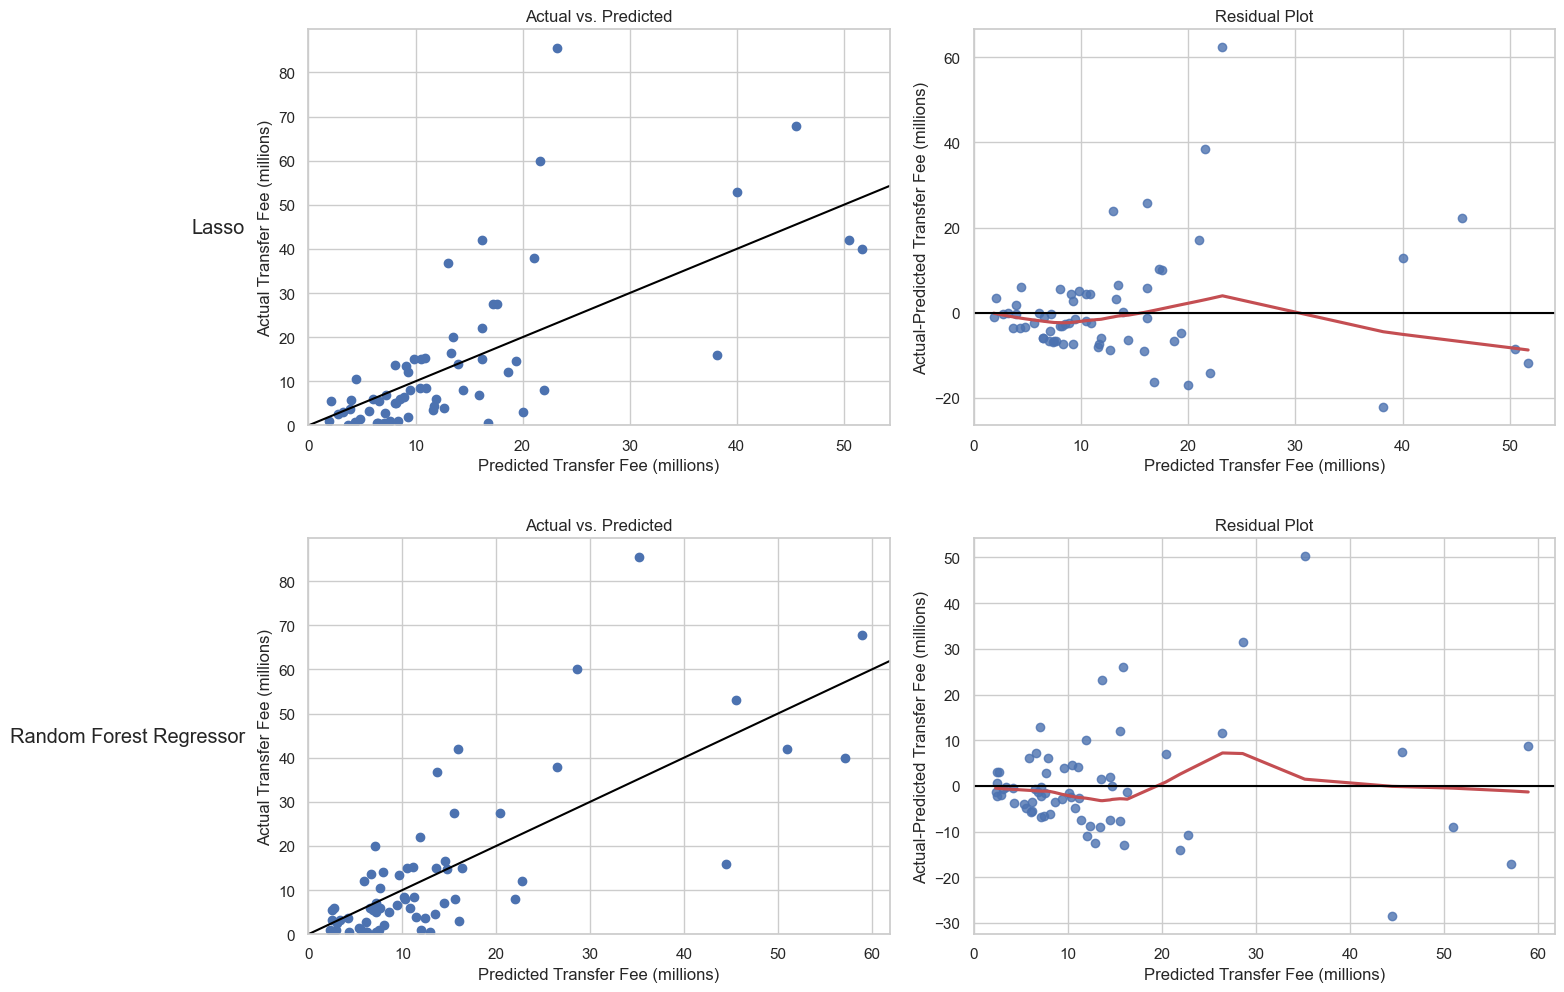

In [261]:
fig, axarr = plt.subplots(2, 2, figsize=(15,10), sharex = False, sharey = False)


rows = ["Lasso", "Random Forest Regressor"]
for ax, row in zip(axarr[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
fig.tight_layout(w_pad = 2, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)


    
#Lasso
predictions12 = Lmod.predict(X_test_fee_sel)/1000000
actual = y_test_fee/1000000

difference = np.subtract(actual, predictions12)

#plot actual vs. prediction + paramater line
axarr[0,0].axline((0, 0), slope=1, color = "black")
axarr[0,0].scatter(x = predictions12, y = actual)
axarr[0,0].axis(xmin=0,ymin=0)

#plot the residuals
sns.regplot(x = predictions12, y = difference, lowess=True, line_kws=dict(color="r"), ax = axarr[0,1])
axarr[0,1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[0,1].axis(xmin=0)



#graph descriptives
labs = axarr[0,0].set(title = "Actual vs. Predicted", xlabel = "Predicted Transfer Fee (millions)", ylabel = "Actual Transfer Fee (millions)")
labs = axarr[0,1].set(title = "Residual Plot", xlabel = "Predicted Transfer Fee (millions)", ylabel = "Actual-Predicted Transfer Fee (millions)") #add legend


#RFR
best_rf.fit(X_train_fee_sel, y_train_fee)
predictions123 = (best_rf.predict(X_test_fee_sel))/1000000
actual = y_test_fee/1000000

difference = np.subtract(actual, predictions123)

#plot actual vs. prediction + paramater line
axarr[1,0].axline((0, 0), slope=1, color = "black")
axarr[1,0].scatter(x = predictions123, y = actual)
axarr[1,0].axis(xmin=0,ymin=0)

#plot the difference
# axarr[2].scatter(x = predictions, y = difference)
sns.regplot(x = predictions123, y = difference, lowess=True, line_kws=dict(color="r"))
axarr[1,1].axhline(y = 0, color = 'black', linestyle = '-')
axarr[1,1].axis(xmin=0)


#graph descriptions
labs = axarr[1,0].set(title = "Actual vs. Predicted", xlabel = "Predicted Transfer Fee (millions)", ylabel = "Actual Transfer Fee (millions)")
labs = axarr[1,1].set(title = "Residual Plot", xlabel = "Predicted Transfer Fee (millions)", ylabel = "Actual-Predicted Transfer Fee (millions)") #add legend

## Bias Audit: Nationality

Used France, Italy, Germany, England because these are European countries that procuce lots of players. 

In [262]:
bias_tf_ds = tf2_data_field[tf2_data_field['nationality_name'].isin(['England', "Italy", "Germany","France"])]


bias_tf_ds.nationality_name.value_counts()

France     87
Italy      64
Germany    58
England    32
Name: nationality_name, dtype: int64

In [263]:
bias_tf_ds_base = bias_tf_ds.groupby("nationality_name", as_index=False)["fee_cleaned"].mean()

In [264]:
bias_tf_ds_base["fee_cleaned"] = bias_tf_ds_base["fee_cleaned"]/1000000


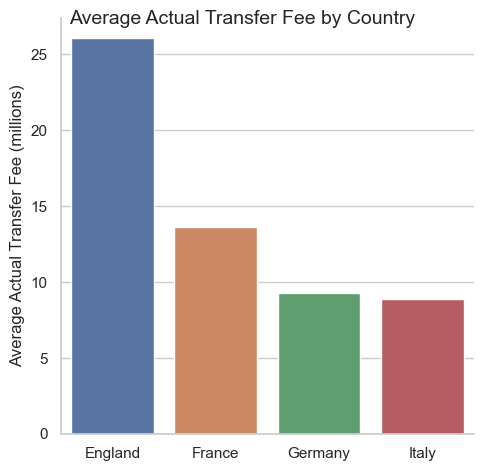

In [265]:
sns.set_theme(style="whitegrid")

p = sns.catplot(data = bias_tf_ds_base, kind = "bar", x = "nationality_name", y = "fee_cleaned", legend_out = False, ci = False)
p.fig.suptitle('Average Actual Transfer Fee by Country', fontsize=14)
p.set_axis_labels("", "Average Actual Transfer Fee (millions)")

This could serve as our base rates in the context of allocative bias

#### New Model for this Specific Data Subset

In [266]:
from sklearn.model_selection import train_test_split
field_tf_bias_train, field_tf_bias_test = train_test_split(bias_tf_ds, test_size = .2, shuffle = True)

In [267]:
#Feature matrix 
#field_tf_bias_train = field_tf_bias_train.drop(["team"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["player_name"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["position_x"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["league_name_x_y"], axis = 1)
#field_tf_bias_train = field_tf_bias_train.drop(["club_involved_name"], axis = 1)
#field_tf_bias_train = field_tf_bias_train.drop(["fee_cleaned"], axis = 1)


#field_tf_bias_test = field_tf_bias_test.drop(["team"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["player_name"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["position_x"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["league_name_x_y"], axis = 1)
#field_tf_bias_test = field_tf_bias_test.drop(["club_involved_name"], axis = 1)
#field_tf_bias_test = field_tf_bias_test.drop(["fee_cleaned"], axis = 1)

#feature engineering on training data
buyer_avg_tf = field_tf_bias_train.groupby("team")["fee_cleaned"].mean()
seller_avg_tf = field_tf_bias_train.groupby("club_involved_name")["fee_cleaned"].mean()

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_bias_train = pd.merge(field_tf_bias_train, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_bias_train = pd.merge(field_tf_bias_train, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_bias_train = field_tf_bias_train.drop(["team"], axis = 1)
field_tf_bias_train = field_tf_bias_train.drop(["club_involved_name"], axis = 1)

#CAN'T do target encoding on test set, because we will get data leakage so we use the buyer_avg_tf and seller_avg_tf from the train set

#left-merge based on "team names"; preserves all rows of tf2_data_field and merges with buyer_avg_tf on matches on "team"
field_tf_bias_test = pd.merge(field_tf_bias_test, buyer_avg_tf, on='team', how='left', suffixes=('', '_buyer_avg'))
field_tf_bias_test = pd.merge(field_tf_bias_test, seller_avg_tf, on='club_involved_name', how='left', suffixes=('', '_seller_avg'))

#drop the categorical features we used for feature engineering
field_tf_bias_test = field_tf_bias_test.drop(["team"], axis = 1)
field_tf_bias_test = field_tf_bias_test.drop(["club_involved_name"], axis = 1)


field_tf_bias_test = field_tf_bias_test.dropna()

#Getting feature matrix and target vector for train, test
X_tf_bias_train = field_tf_bias_train.drop(["fee_cleaned"], axis = 1)
X_tf_bias_train = X_tf_bias_train.drop(["nationality_name"], axis = 1)
y_tf_bias_train = field_tf_bias_train["fee_cleaned"]



X_tf_bias_test = field_tf_bias_test.drop(["fee_cleaned"], axis = 1)
X_tf_bias_test = X_tf_bias_test.drop(["nationality_name"], axis = 1)
y_tf_bias_test = field_tf_bias_test["fee_cleaned"]

#### Note: Use Lmod, our lasso model with tuned hyperparameters on whole dataset for the model we will audit for bias.

In [268]:
#likely biased
Lmod.fit(X_tf_bias_train, y_tf_bias_train)
model_scores = cross_val_score(Lmod, X_tf_bias_train, y_tf_bias_train, cv = 5)
print(model_scores.mean())

print(Lmod.score(X_tf_bias_test, y_tf_bias_test))

0.5737907841142486
0.015211776828464307


Can use cross_val here because 

In [280]:
bias_ds2 = field_tf_bias_train.copy()
bias_ds2.rename(columns={'fee_cleaned':'Actual'}, inplace=True)
bias_ds2["Predicted"] = Lmod.predict(X_tf_bias_train)

In [281]:
bias_ds2["Actual"] = bias_ds2["Actual"]/1000000
bias_ds2["Predicted"] = bias_ds2["Predicted"]/1000000

In [282]:
bias_ds2_preds = bias_ds2.groupby(["nationality_name"], as_index=False)["Predicted"].mean()

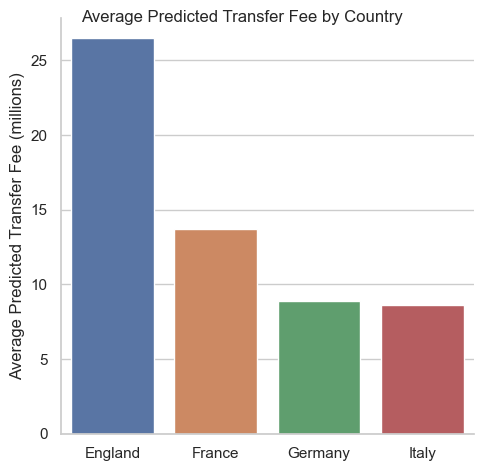

In [283]:
p = sns.catplot(data = bias_ds2_preds, kind = "bar", x = "nationality_name", y = "Predicted", legend_out = False)
p.fig.suptitle('Average Predicted Transfer Fee by Country', fontsize=12)
p.set_axis_labels("", "Average Predicted Transfer Fee (millions)")

In [284]:
names = bias_ds2_preds["nationality_name"].drop_duplicates()
names = names.reset_index(drop=True)

In [285]:
bias_ds2_act_pred1 = bias_ds2.groupby(["nationality_name"], as_index=False)["Actual","Predicted"].mean()
bias_ds2_mean_residuals = pd.DataFrame(bias_ds2_act_pred1.loc[:, 'Actual'] - bias_ds2_act_pred1.loc[:, 'Predicted'], columns = ["Differences"])
bias_ds2_mean_residuals["nationality_name"] = names

In [286]:
bias_ds2_act_pred2 = bias_ds2.groupby(["nationality_name"], as_index=False)["Actual","Predicted"].median()
bias_ds2_median_residuals = pd.DataFrame(bias_ds2_act_pred2.loc[:, 'Actual'] - bias_ds2_act_pred2.loc[:, 'Predicted'], columns = ["Differences"])
bias_ds2_median_residuals["nationality_name"] = names

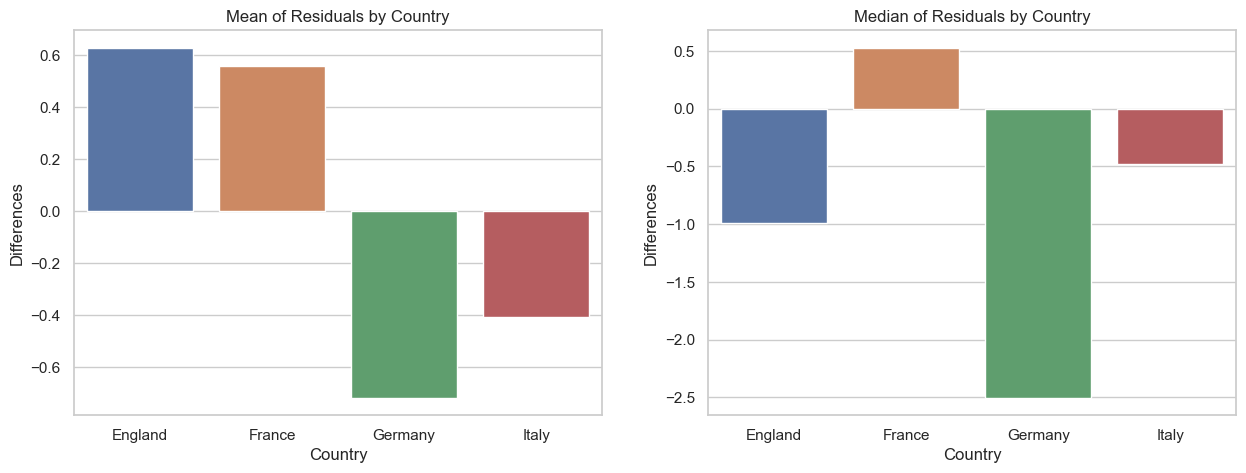

In [287]:
fig, axarr = plt.subplots(1, 2, figsize=(15,5), sharex = False, sharey = False)

p = sns.barplot(data = bias_ds2_mean_residuals, x = "nationality_name", y = "Differences", ax = axarr[0])
p = sns.barplot(data = bias_ds2_median_residuals, x = "nationality_name", y = "Differences", ax = axarr[1])
labs = axarr[0].set(title = "Mean of Residuals by Country", xlabel = "Country")
labs = axarr[1].set(title = "Median of Residuals by Country", xlabel = "Country")

In [277]:
group_test = bias_ds2["nationality_name"]

In [278]:
England_resids = (bias_ds2[group_test == "England"]["Actual"]) - (bias_ds2[group_test == "England"]["Predicted"])
France_resids = (bias_ds2[group_test == "France"]["Actual"]) - (bias_ds2[group_test == "France"]["Predicted"])
Germany_resids = (bias_ds2[group_test == "Germany"]["Actual"]) - (bias_ds2[group_test == "Germany"]["Predicted"])
Italy_resids = (bias_ds2[group_test == "Italy"]["Actual"]) - (bias_ds2[group_test == "Italy"]["Predicted"])

[-25.0, 25.0, -25.0, 25.0, -25.0, 25.0, -25.0, 25.0]

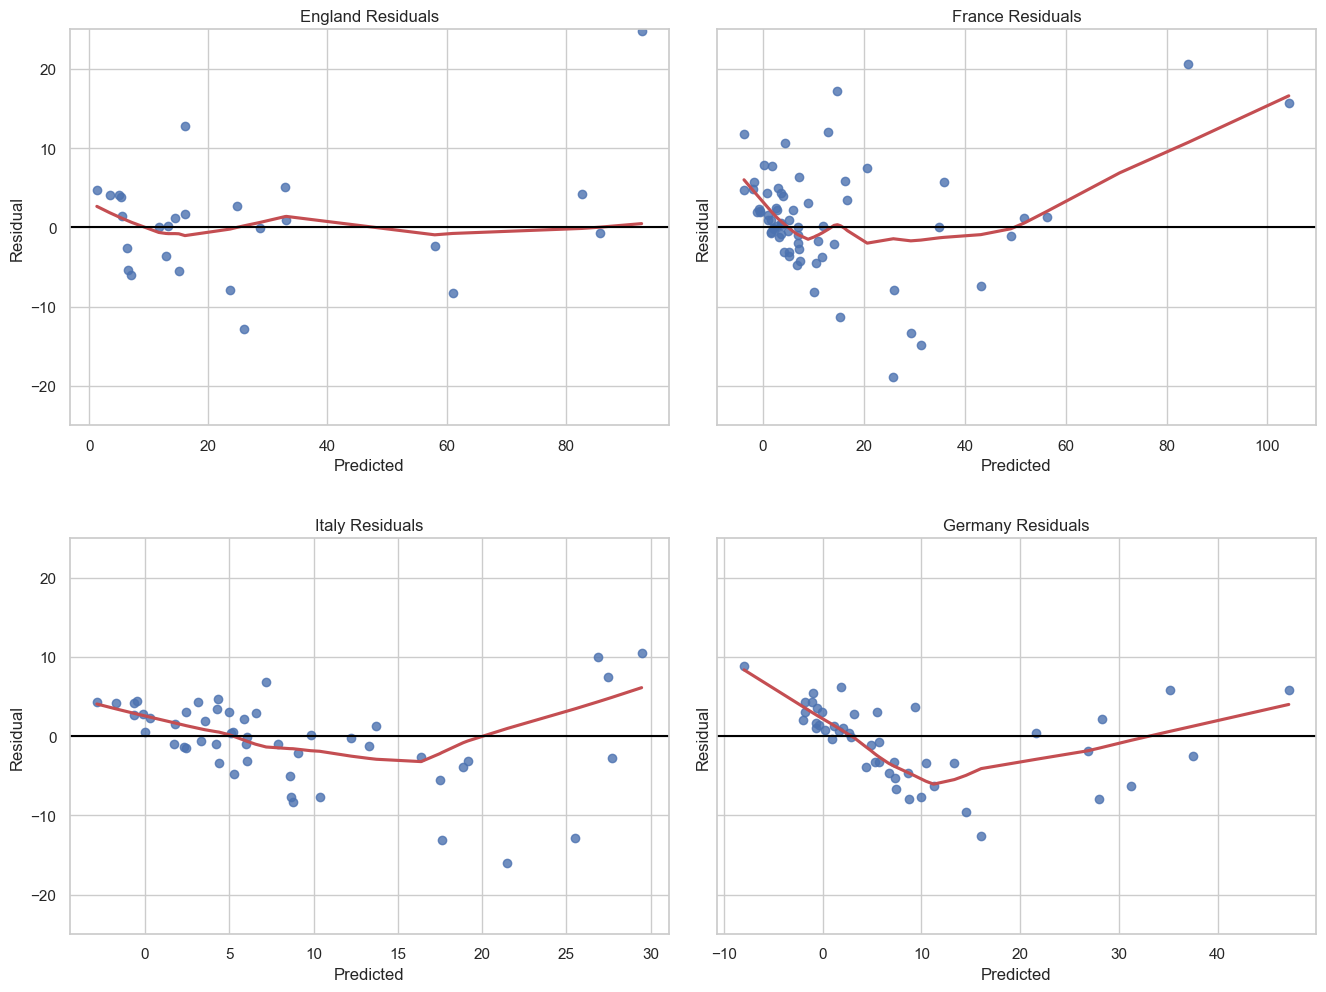

In [279]:
fig, axarr = plt.subplots(2, 2, figsize=(15,10), sharex = False, sharey = True)


fig.tight_layout(w_pad = 2, h_pad = 5)
fig.subplots_adjust(left=0.15, top=0.95)

#title each one
sns.regplot(x = bias_ds2[group_test == "England"]["Predicted"], y = England_resids, lowess=True, line_kws=dict(color="r"), ax = axarr[0,0])
axarr[0,0].axhline(y = 0, color = 'black', linestyle = '-')
labs = axarr[0,0].set(title = "England Residuals", xlabel = "Predicted", ylabel = "Residual")

sns.regplot(x = bias_ds2[group_test == "France"]["Predicted"], y = France_resids, lowess=True, line_kws=dict(color="r"), ax = axarr[0,1])
axarr[0,1].axhline(y = 0, color = 'black', linestyle = '-')
labs = axarr[0,1].set(title = "France Residuals", xlabel = "Predicted", ylabel = "Residual")

sns.regplot(x = bias_ds2[group_test == "Italy"]["Predicted"], y = Italy_resids, lowess=True, line_kws=dict(color="r"), ax = axarr[1,0])
axarr[1,0].axhline(y = 0, color = 'black', linestyle = '-')
labs = axarr[1,0].set(title = "Italy Residuals", xlabel = "Predicted", ylabel = "Residual")
      
sns.regplot(x = bias_ds2[group_test == "Germany"]["Predicted"], y = Germany_resids, lowess=True, line_kws=dict(color="r"), ax = axarr[1,1])
axarr[1,1].axhline(y = 0, color = 'black', linestyle = '-')
labs = axarr[1,1].set(title = "Germany Residuals", xlabel = "Predicted", ylabel = "Residual")

# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (-25, 25)

# Setting the values for all axes.
plt.setp(axarr, ylim=custom_ylim)

In [212]:
#find threshold for good / bad predictions; # of good vs. number of bad predictions

(0.0, 1.0)

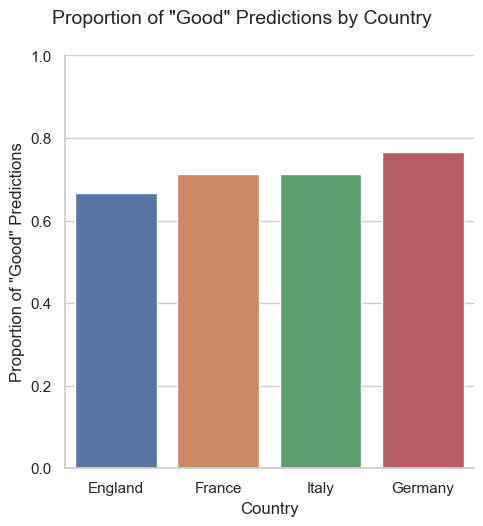

In [503]:
# Create a list of countries
countries = ['England', 'France', 'Italy', 'Germany']

#Create list of "good" predictions
results = [(England_resids.abs() < 5).value_counts(normalize=True)[True], 
          (France_resids.abs() < 5).value_counts(normalize=True)[True],
          (Italy_resids.abs() < 5).value_counts(normalize=True)[True],
          (Germany_resids.abs() < 5).value_counts(normalize=True)[True]]

# Create a DataFrame with this info
df = pd.DataFrame({'nationality_name': countries, "good_predictions": results})

p = sns.catplot(data = df, kind = "bar", x = "nationality_name", y = "good_predictions", legend_out = True)
p.fig.suptitle('Proportion of "Good" Predictions by Country', fontsize=14, y = 1.05)
p.set_axis_labels("Country", 'Proportion of "Good" Predictions')
plt.ylim(0, 1)
#